In [1]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

import pandas as pd
import numpy as np
import csv
import torch
import ctypes
import gc
import os

import dataset
import torch
import warnings

import pandas as pd
import numpy as np
import torch.nn as nn

from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
torch.manual_seed(42)
os.environ['PJRT_DEVICE'] = 'TPU' 
warnings.filterwarnings("ignore")
libc = ctypes.CDLL("libc.so.6")

In [2]:
from tqdm import tqdm
import gc
from PIL import Image
X = []
y = []
for i in tqdm(range(50000)):
    with Image.open(f'/home/shashank/Extracted/0/{i+1}.png') as img:
        img_arr = np.array(img).reshape((125,125,8))
        X.append(img_arr)
        y.append(0)
        
    with Image.open(f'/home/shashank/Extracted/1/{i+1}.png') as img:
        img_arr = np.array(img).reshape((125,125,8))
        X.append(img_arr)
        y.append(1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:25<00:00, 582.50it/s]


In [3]:
length = len(X)
X_train = X[:int(0.8*length)]
X_test = X[int(0.8*length): int(length)]

In [15]:
import numpy as np

import torch

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

class Transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore
    
    def forward(self, x):
        
#         imgs = self.patchify(x)

        
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        
        return x, mask, ids_restore
    
class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.block = Transformer_block(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)

        
    def forward(self, x):
        encoded_tensor = []
        masks = []
        ids = []
        
        for i in range(8):
            img = x[:,i,:,:].unsqueeze(1)
            op, mask, ids_restore = self.block(img)
            encoded_tensor.append(op)
            masks.append(mask)
            ids.append(ids_restore)
            
        img = self.block.patchify(x)
            
        return encoded_tensor, masks, ids, img
    
import torchvision
from torchview import draw_graph
from torchviz import make_dot
# encoder = Encoder(
#         img_size=125, patch_size=5, embed_dim=96, depth=10, num_heads=8,in_chans = 1,
#         mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))

# model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
# model_graph.visual_graph
# encoder.load_state_dict(torch.load('/home/shashank/Model_files/encoder.pth'))
class Decoder_transformer_block(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * 8, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 8, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 8, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def forward(self, x):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
#         mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
#         x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
#         x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
#         x =   # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x
    
class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
             embed_dim=1024, depth=24, num_heads=16,
             decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
             mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()
        
        self.block = Decoder_transformer_block(img_size=img_size, patch_size=patch_size, in_chans=in_chans,
                                                 embed_dim=embed_dim, depth=depth, num_heads=num_heads,
                                                 decoder_embed_dim=decoder_embed_dim, decoder_depth=decoder_depth, decoder_num_heads=decoder_num_heads,
                                                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False)
        
        self.mask_token = nn.Parameter(torch.zeros(1, 1, 96))
        
    def forward(self, x, ids):
        
        op = []
        cls_token = []
        for i in range(len(x)):
#             print(x[i].shape)
            mask_tokens = self.mask_token.repeat(x[i].shape[0], ids[i].shape[1] + 1 - x[i].shape[1], 1)
            x_ = torch.cat([x[i][:, 1:, :], mask_tokens], dim=1)  # no cls token
            cls_token.append(x[i][:,:1,:])
            x_ = torch.gather(x_, dim=1, index=ids[i].unsqueeze(-1).repeat(1, 1, x[i].shape[2]))  # unshuffle
            op.append(x_)
    
        op = torch.cat(op, axis = 2)
        cls_token = torch.cat(cls_token, axis = 2)
#         print(op.shape)
        op = torch.cat([cls_token, op], dim=1)
#         print(op.shape)
        op = self.block(op)
        return op

class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        x, mask, ids_restore, img = self.encoder(x)
        pred = self.decoder(x, ids_restore)
        
        return pred, mask, img
    
def mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=5, embed_dim=96, depth=10, num_heads=8,in_chans = 1,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=4, num_heads=8,in_chans = 1,
        decoder_embed_dim=512, decoder_depth=2, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

# Instantiate the model
model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)
model.load_state_dict(torch.load('./Model_files/xla_trained_model_epoch.pth'))

<All keys matched successfully>

In [25]:
class VIT_classifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        # self.patch_embed = encoder.block.patch_embed
        # self.cls_token = encoder.block.cls_token
        # self.pos_embed = encoder.block.pos_embed  # Corrected attribute name
        # self.patchify = encoder.block.patchify
        # self.transformer = encoder.block  # Corrected attribute name
        # self.layer_norm = encoder.block.norm  # Corrected attribute name
        # self.head = torch.nn.Linear(self.pos_embed.shape[-1], num_classes)
        # self.blocks = encoder.block
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        self.avg_pool = nn.AdaptiveAvgPool1d((1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_features=157, out_features=32)
        self.fc_1 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        x, _, _, _ = self.encoder(x)
        x = torch.cat(x, axis = 2)
        # x = self.layer_norm(x)
        
        # x = x[:,1:,:]
        x = self.avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.fc_1(x)
        x = self.sigmoid(x)
        
        return x

def Classifier():
    encoder = model.encoder
    classifier = VIT_classifier(encoder, 2)
    return classifier
    
cls = Classifier()

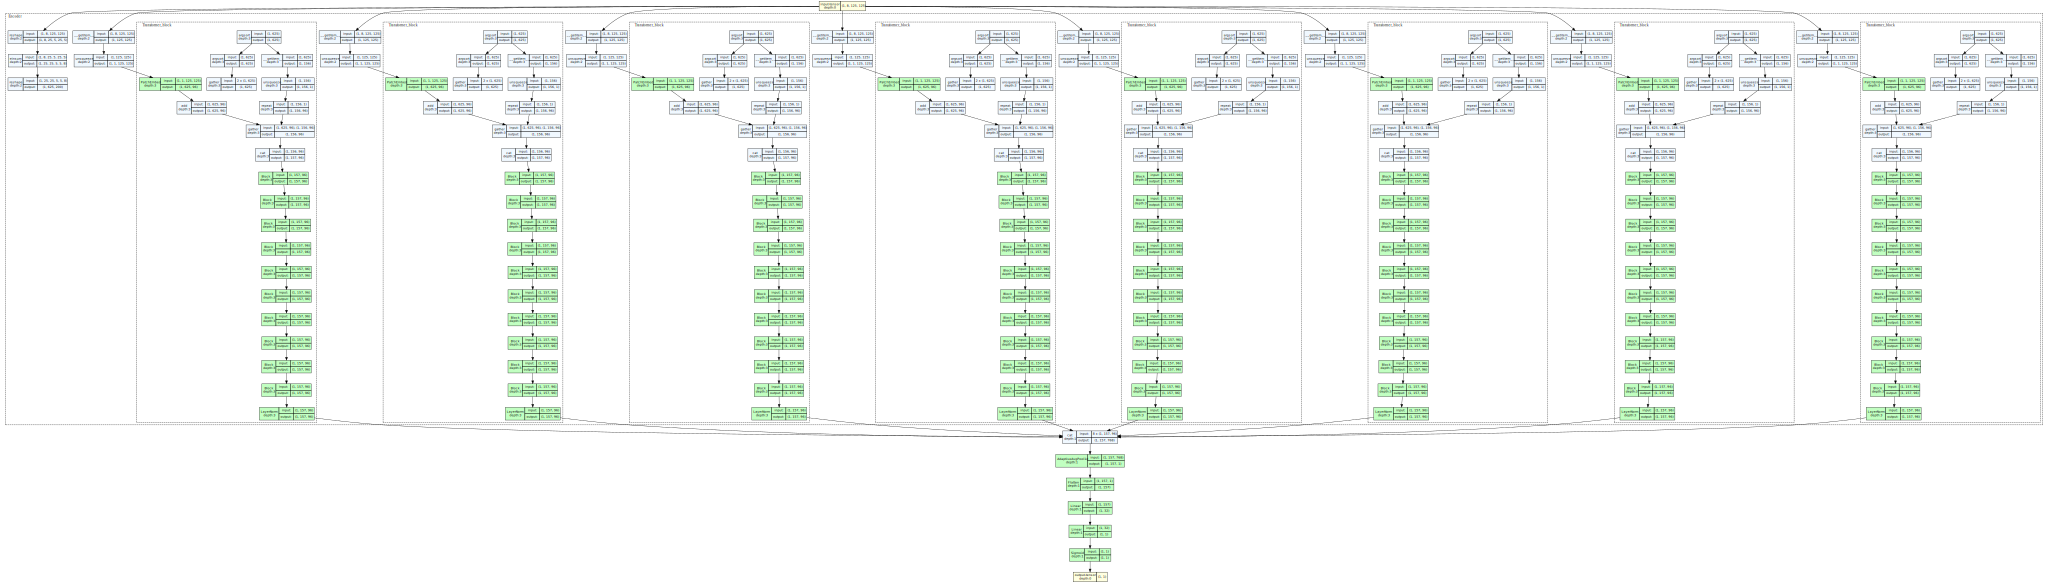

In [26]:
model_graph = draw_graph(cls, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph

In [7]:
X_train = np.array(X_train)
X_test = np.array(X_test)
# Initialize lists to hold means and stds for each channel
mean = []
std = []

# Calculate mean and std for each channel
for i in range(X_train.shape[-1]):  # Assuming the last dimension is the channel
    mean.append(X_train[:, :, :, i].mean())
    std.append(X_train[:, :, :, i].std())

# Normalize each channel
for i in range(X_train.shape[-1]):
    X_train[:, :, :, i] = (X_train[:, :, :, i] - mean[i]) / std[i]
    X_test[:, :, :, i] = (X_test[:, :, :, i] - mean[i]) / std[i]

# Perform zero suppression
X_train[X_train < 1e-3] = 0

In [8]:
length = len(X)
Y_train = y[:int(0.8*(length))]
Y_test = y[int(0.8*(length)):length]

In [36]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class Custom_Dataset(Dataset):
    def __init__(self, x, y, transform):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = self.x[idx].astype('float32')
        label = torch.tensor(self.y[idx].astype('float32'))
        
        if self.transform:
            img_1 = self.transform(img_1)
            
        sample = {'img' : img_1, 'label' : label}
        
        return sample
    
## Train dataset transformations
train_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.RandomRotation(60),])

## Test dataset transformations
test_transform = transforms.Compose([
                            transforms.ToTensor(),])

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
train_dataset = Custom_Dataset(X_train, Y_train, transform = train_transform)
test_dataset = Custom_Dataset(X_test, Y_test, transform = test_transform)

sample = train_dataset.__getitem__(0)
print((sample['img']).max())
print(sample['label'].dtype)

tensor(85.)
torch.float32


In [37]:
def reduce_fn(vals):
    # take average
    return sum(vals) / len(vals)

In [38]:
from torch import tensor
from torchmetrics.functional.classification import binary_accuracy
target = tensor([0, 1, 0, 1, 0, 1])
preds = tensor([0, 0, 1, 1, 0, 1])
binary_accuracy(preds, target).item()

0.6666666865348816

In [42]:
# from torchmetrics import Accuracy
# from torchmetrics.classification import BinaryAccuracy
# def train_one_epoch(model, train_dataloader, valid_dataloader, criterion, scheduler, device, optimizer):
#     train_loss = []
#     valid_loss = []
#     train_accuracies = []
#     val_accuracies = []
#     accuracy = BinaryAccuracy().to(device)
    
#     model.train()
#     scheduler.step()

#     for step, batch in (enumerate(train_dataloader)):
#         image = batch['img'].to(device)
#         label = batch['label'].to(device)
#         optimizer.zero_grad()

#         outputs = model(image).squeeze()
#         loss = criterion(outputs, label)
#         loss.backward()
#         xm.optimizer_step(optimizer)
        
#         if step%1000 == 0:
#             xm.master_print(f'Train_Batch: {step}, loss: {loss.item()}')

#         loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
#         train_loss.append(loss_reduced.detach().cpu().numpy())
        
#         # Calculate training accuracy
#         train_acc = accuracy(outputs, label)
#         train_accuracies.append(train_acc.item())
#         gc.collect()

#     model.eval()
#     with torch.no_grad():
#         for step, batch in (enumerate(valid_dataloader)):
#             image = batch['img'].to(device)
#             label = batch['label'].to(device)
#             optimizer.zero_grad()
    
#             outputs = model(image).squeeze()
#             loss = criterion(outputs, label)
#             loss_reduced = xm.mesh_reduce('loss_reduce',loss,reduce_fn) 
#             valid_loss.append(loss_reduced.detach().cpu().numpy())
            
#             # Calculate validation accuracy
#             val_acc = accuracy(outputs, label)
#             val_accuracies.append(val_acc.item())
            
#             if step%500 == 0:
#                 xm.master_print(f'Train_Batch: {step}, loss: {loss.item()}')
#             gc.collect()

#     return np.mean(train_loss), np.mean(valid_loss), np.mean(train_accuracies), np.mean(val_accuracies)
from torchmetrics.classification import BinaryAccuracy

def train_one_epoch(model, train_dataloader, valid_dataloader, criterion, scheduler, device, optimizer):
    train_loss = []
    valid_loss = []
    train_accuracies = []
    val_accuracies = []
    accuracy = BinaryAccuracy().to(device)
    
    model.train()
    scheduler.step()

    for step, batch in enumerate(train_dataloader):
        image = batch['img'].to(device)
        label = batch['label'].to(device)
        optimizer.zero_grad()

        outputs = model(image).squeeze()
        loss = criterion(outputs, label)
        loss.backward()
        xm.optimizer_step(optimizer)
        
        if step % 1000 == 0:
            xm.master_print(f'Train_Batch: {step}, loss: {loss.item()}')

        loss_reduced = xm.mesh_reduce('loss_reduce', loss, reduce_fn) 
        train_loss.append(loss_reduced.detach().cpu().numpy())
        
        # Calculate training accuracy
        train_acc = accuracy(outputs, label)
        train_accuracies.append(train_acc.item())
        
        gc.collect()

    model.eval()
    with torch.no_grad():
        for step, batch in enumerate(valid_dataloader):
            image = batch['img'].to(device)
            label = batch['label'].to(device)
    
            outputs = model(image).squeeze()
            loss = criterion(outputs, label)
            loss_reduced = xm.mesh_reduce('loss_reduce', loss, reduce_fn) 
            valid_loss.append(loss_reduced.detach().cpu().numpy())
            
            # Calculate validation accuracy
            
            val_acc = accuracy(outputs, label)
            val_accuracies.append(val_acc.item())
            
            if step % 500 == 0:
                xm.master_print(f'Valid_Batch: {step}, loss: {loss.item()}')
            gc.collect()

    return np.mean(train_loss), np.mean(valid_loss), np.mean(train_accuracies), np.mean(val_accuracies)


In [43]:
def data():
    ## Train dataset transformations
    train_transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(60),])

    ## Test dataset transformations
    test_transform = transforms.Compose([
                                transforms.ToTensor(),])

    ##Train Dataset
    train_dataset = Custom_Dataset(X_train, Y_train,  transform = train_transform)
    
    ##Test Dataset
    test_dataset = Custom_Dataset(X_test, Y_test, transform = test_transform)
    
    ##Sampler
    train_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    train_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = True
                                                                    )
    
    ##Train Dataloader
    dataloader_train = torch.utils.data.DataLoader(train_dataset,
                                                    batch_size=128,
                                                    sampler = train_sampler,
                                                    drop_last = True,
                                                    num_workers=1,
                                                    pin_memory = True)
    
    
    ##Sampler
    valid_sampler = torch.utils.data.distributed.DistributedSampler(
                                                                    test_dataset,
                                                                    num_replicas=xm.xrt_world_size(),
                                                                    rank=xm.get_ordinal(),
                                                                    shuffle = False
                                                                    )
    ##Test Dataloader
    dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                                  sampler = valid_sampler,
                                                  batch_size=128,
                                                  drop_last = True,
                                                  num_workers=1,
                                                 )
    return dataloader_train, dataloader_test

In [ ]:

def train_function(model, epochs):
    criterion = nn.BCELoss()
    lr = 0.0001
    num_train_steps = int(
        len(X_train) / 64 / xm.xrt_world_size() * epochs
    )

    lr = lr * xm.xrt_world_size()
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_train_steps
    )

    train_dataloader, test_dataloader = data()
    
    xm.master_print(f'num_training_steps = {num_train_steps}, world_size={xm.xrt_world_size()}')
    device = xm.xla_device()
    model = model.to(device)
    
    train_loss = []
    valid_loss = []
    for epoch in tqdm(range(epochs)):
        gc.collect()
        para_loader = pl.ParallelLoader(train_dataloader, [device])
        train_loader = para_loader.per_device_loader(device)

        val_loader = pl.ParallelLoader(test_dataloader, [device])
        valid_loader = val_loader.per_device_loader(device)
        
        trn_loss, val_loss, train_acc, val_acc = train_one_epoch(model, train_loader, valid_loader, criterion, scheduler, device, optimizer)
        
        scheduler.step()
        train_loss.append(trn_loss)
        valid_loss.append(val_loss)
        gc.collect()

        xm.master_print(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')
        with open('losses.txt', 'a') as f:
            f.write(f'Epoch {epoch+1}/{epochs}, Train Loss: {trn_loss:.4f}, Val Loss: {val_loss:.4f}\n')
        
    xm.rendezvous('save_model')
    xm.master_print('save model')
    xm.save(model.state_dict(), f'./Model_files/xla_trained_model_epoch.pth')

def _mp_fn(rank, flags):
    try:
        model = Classifier()
        dev = xm.xla_device()
        model = model.to(dev)
        dataloader_train, dataloader_test = data()
        torch.set_default_tensor_type('torch.FloatTensor')
        train_function(model, epochs=50)
        # xser.save(model.state_dict(), f"model.bin", master_only=True)
    except Exception as e:
        print(f"Exception in process {rank}: {e}")
        raise

if __name__ == '__main__':
    FLAGS = {}
    try:
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=8, start_method='fork')
    except Exception as e:
        print(f"Exception in main: {e}")

I0000 00:00:1718120525.143717  675784 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718120525.143717  675785 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718120525.143832  675784 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1718120525.143834  675785 pjrt_api.cc:79] PJRT_Api is set for device type tpu
I0000 00:00:1718120525.143842  675784 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API version is 0.46.
I0000 00:00:1718120525.143842  675785 pjrt_api.cc:146] The PJRT plugin has PJRT API version 0.46. The framework PJRT API version is 0.46.
I0000 00:00:1718120525.143803  675782 pjrt_api.cc:100] GetPjrtApi was found for tpu at /home/shashank/.local/lib/python3.10/site-packages/libtpu/libtpu.so
I0000 00:00:1718120525.143935  675782 pjrt_api.cc:79] PJRT_Api is set for devic

num_training_steps = 15625, world_size=4


  0%|                                                                                                                        | 0/50 [00:00<?, ?it/s]

Train_Batch: 0, loss: 0.7077214121818542
Valid_Batch: 0, loss: 0.7026211023330688
Epoch 1/50, Train Loss: 0.6927, Val Loss: 0.6921, Train Accuracy: 0.5292, Val Accuracy: 0.0052


  2%|██▏                                                                                                          | 1/50 [03:32<2:53:47, 212.80s/it]

Train_Batch: 0, loss: 0.6898008584976196
Valid_Batch: 0, loss: 0.7062699794769287


  4%|████▎                                                                                                        | 2/50 [05:15<1:58:38, 148.31s/it]

Epoch 2/50, Train Loss: 0.6914, Val Loss: 0.6909, Train Accuracy: 0.5597, Val Accuracy: 0.0561

  4%|████▎                                                                                                        | 2/50 [05:15<1:58:40, 148.35s/it]

  4%|████▎                                                                                                        | 2/50 [05:16<1:58:49, 148.54s/it]

Train_Batch: 0, loss: 0.6872313022613525
Valid_Batch: 0, loss: 0.710938572883606
Epoch 3/50, Train Loss: 0.6896, Val Loss: 0.6891, Train Accuracy: 0.5938, Val Accuracy: 0.1282


  6%|██████▌                                                                                                      | 3/50 [07:07<1:43:05, 131.60s/it]

Train_Batch: 0, loss: 0.6834900379180908
Valid_Batch: 0, loss: 0.7154037952423096


  8%|████████▋                                                                                                    | 4/50 [08:50<1:32:07, 120.17s/it]

Epoch 4/50, Train Loss: 0.6868, Val Loss: 0.6863, Train Accuracy: 0.6261, Val Accuracy: 0.2101


  8%|████████▋                                                                                                    | 4/50 [08:50<1:32:15, 120.33s/it]

Train_Batch: 0, loss: 0.6794575452804565
Valid_Batch: 0, loss: 0.7229362726211548


 10%|██████████▉                                                                                                  | 5/50 [10:32<1:25:07, 113.49s/it]

Epoch 5/50, Train Loss: 0.6828, Val Loss: 0.6825, Train Accuracy: 0.6334, Val Accuracy: 0.2664


 10%|██████████▉                                                                                                  | 5/50 [10:32<1:25:08, 113.53s/it]

Train_Batch: 0, loss: 0.6729274392127991
Valid_Batch: 0, loss: 0.7300676703453064


 12%|█████████████                                                                                                | 6/50 [12:15<1:20:39, 110.00s/it]

Epoch 6/50, Train Loss: 0.6779, Val Loss: 0.6783, Train Accuracy: 0.6418, Val Accuracy: 0.3163


 12%|█████████████                                                                                                | 6/50 [12:15<1:20:40, 110.02s/it]

Train_Batch: 0, loss: 0.6644269227981567
Valid_Batch: 0, loss: 0.7373265624046326


 14%|███████████████▎                                                                                             | 7/50 [13:54<1:16:20, 106.53s/it]

Epoch 7/50, Train Loss: 0.6722, Val Loss: 0.6736, Train Accuracy: 0.6449, Val Accuracy: 0.3492

 14%|███████████████▎                                                                                             | 7/50 [13:54<1:16:20, 106.53s/it]

 14%|███████████████▎                                                                                             | 7/50 [13:54<1:16:21, 106.54s/it]

Train_Batch: 0, loss: 0.6615553498268127
Valid_Batch: 0, loss: 0.7419280409812927


 16%|█████████████████▍                                                                                           | 8/50 [15:38<1:14:03, 105.80s/it]

Epoch 8/50, Train Loss: 0.6666, Val Loss: 0.6690, Train Accuracy: 0.6461, Val Accuracy: 0.3878


 16%|█████████████████▍                                                                                           | 8/50 [15:39<1:14:08, 105.92s/it]

Train_Batch: 0, loss: 0.643416702747345
Valid_Batch: 0, loss: 0.7490372061729431


 18%|███████████████████▌                                                                                         | 9/50 [17:18<1:10:57, 103.83s/it]

Epoch 9/50, Train Loss: 0.6610, Val Loss: 0.6647, Train Accuracy: 0.6477, Val Accuracy: 0.4052


 18%|███████████████████▌                                                                                         | 9/50 [17:18<1:10:58, 103.87s/it]

Train_Batch: 0, loss: 0.6437943577766418
Valid_Batch: 0, loss: 0.7453611493110657
Epoch 10/50, Train Loss: 0.6557, Val Loss: 0.6617, Train Accuracy: 0.6459, Val Accuracy: 0.4205


 20%|█████████████████████▌                                                                                      | 10/50 [19:04<1:09:43, 104.59s/it]